### Contexto

Palmirinha quer estudar os fatores que fazem uma batelada de pamonha ser classificada como boa ou ruim.

Ao longo de sua longa carreira Palmirinha -- sendo extremamente meticulosa -- anotou os resultados de milhares de experimentos de degustação, disponíveis em qualidade_pamonha.csv. Nestes experimentos, temos informações sobre:

- o ano em que o experimento foi feito
 
- a temperatura (em graus Celsius) em que a pamonha foi servida

- o potencial de hidrogênio (pH) da pamonha

- o tipo de milho que foi utilizado para a pamonha

- o teor de sacarose na pamonha (em %)

- se foi considerada boa (1) ou ruim (0).

### Objetivo

Com a ajuda de seu fiel escudeiro, Guinho, ela pretende utilizar esses dados para entender quais os fatores fazem com que a pamonha seja classificada como boa, de modo a criar a pamonha perfeita.

Ajude Palmirinha e Guinho nesta tarefa. Lembre-se de empregar ferramentas de vizualização de dados e de avaliação de modelos que façam sentido para o tipo de dado disponível.

In [4]:
library(tidyverse)
library(GGally)  # ggpairs
library(MuMIn)  # AICc (Akaike Information Criterion corrected for small sample size)
library(MASS)  # negative.binomial
library(readr)
library(ggplot2)
library(gridExtra)
library(rstanarm)
library(pROC)

urlfile = "https://raw.githubusercontent.com/maxbiostat/stats_modelling/master/data/qualidade_pamonha.csv"
data <- read_csv(url(urlfile))

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.0     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.1.8
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select



Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine


Carregando pacotes exigidos: Rcpp

This is rstanarm version 2.21.4

- See https://mc-stan.org/rstanarm/articles/priors for changes to default priors!

- Default priors may change, so it's safest to

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


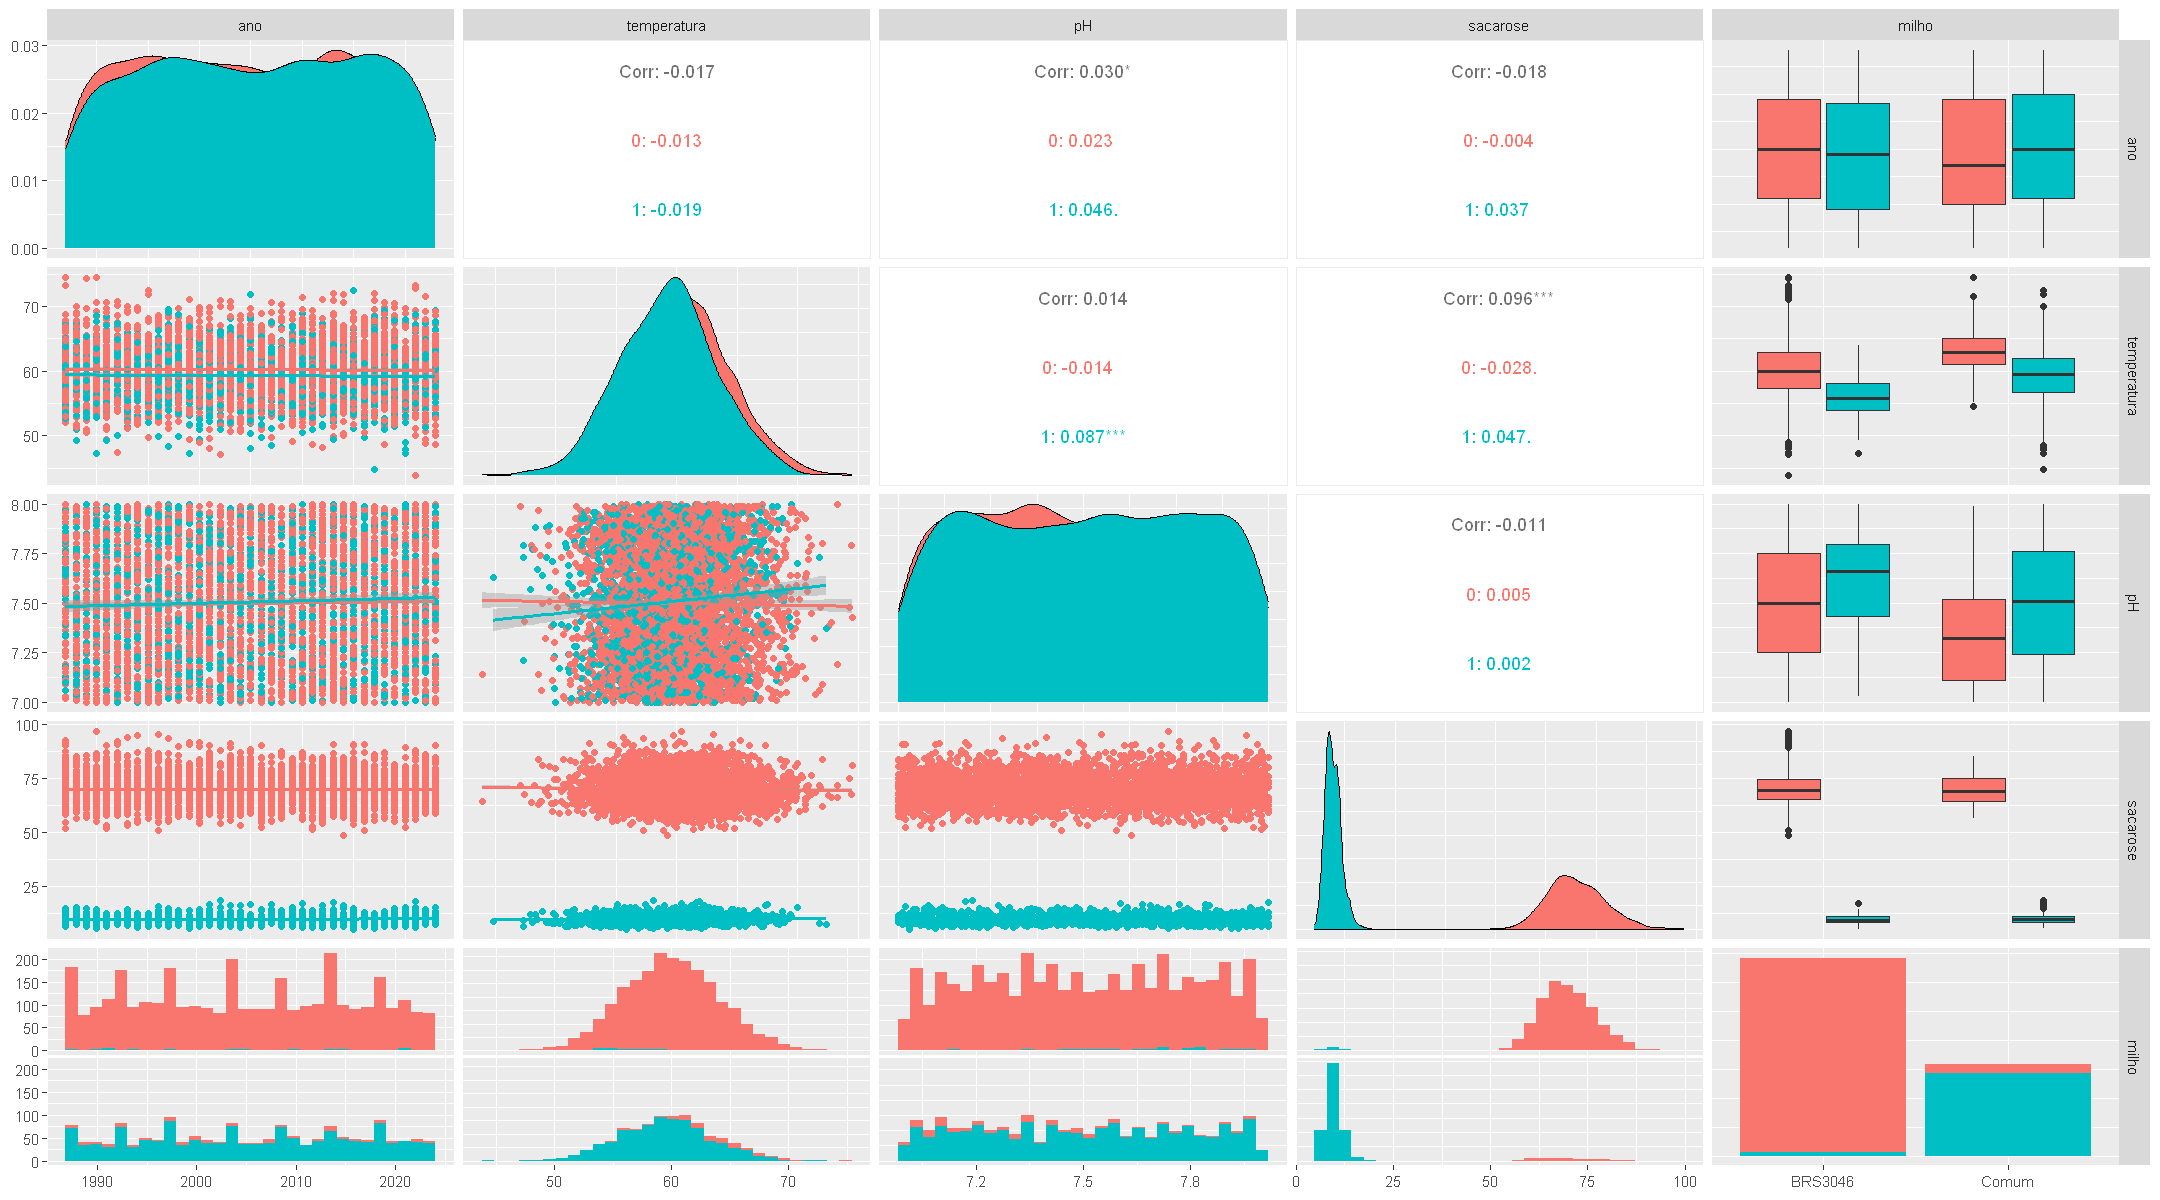

In [27]:
options(repr.plot.width = 18, repr.plot.height = 10)
ggpairs(data, columns = c("ano", "temperatura", "pH", "sacarose","milho"),
        aes(colour = as.factor(boa)), lower = list(continuous = wrap("smooth", method = "lm")))

#### Temperatura x Average Boa

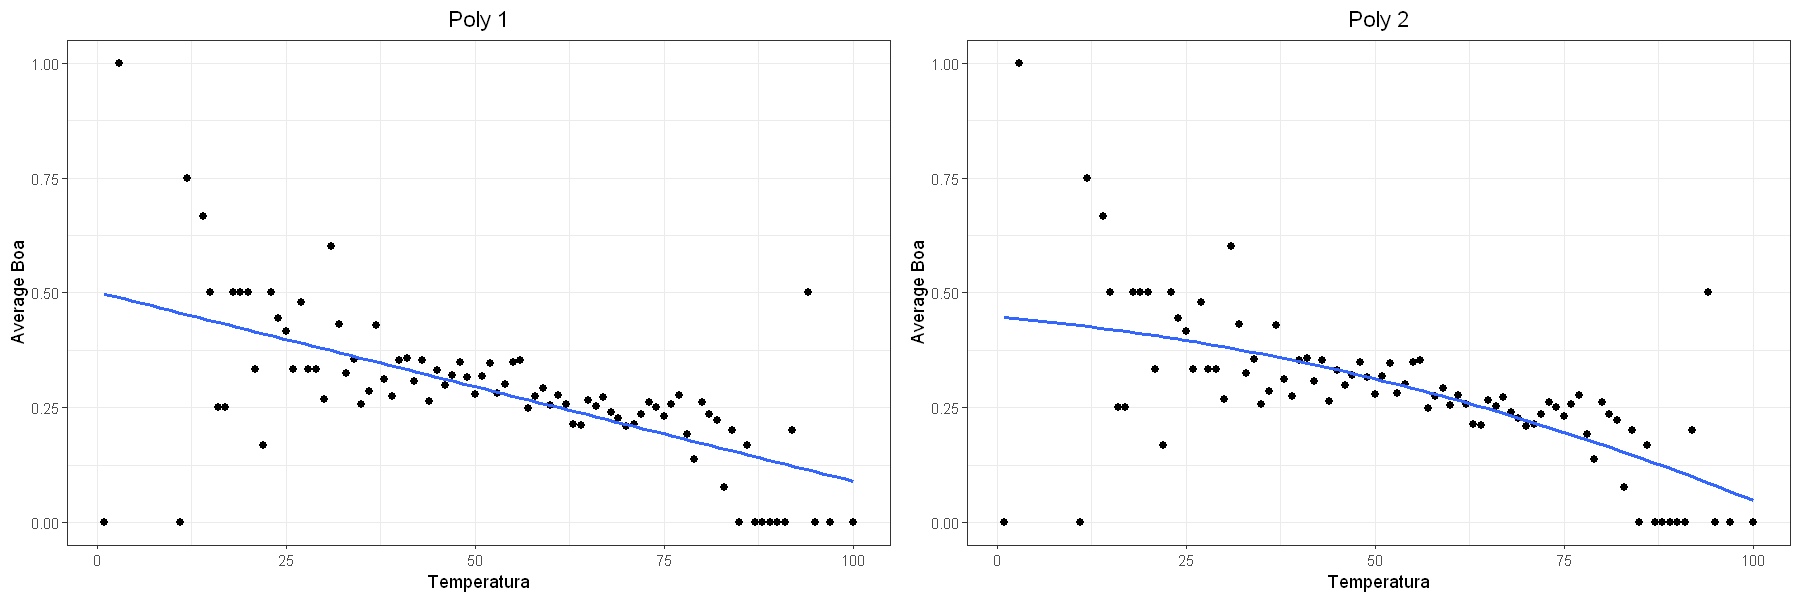

In [45]:
data2 <- data %>%
  mutate(temperatura_group = cut(temperatura, breaks = 100))

averages <- data2 %>%
  group_by(temperatura_group) %>%
  summarize(average_boa = mean(boa))

options(repr.plot.width = 15, repr.plot.height = 5)
chart <- ggplot(data = averages, aes(x = as.numeric(temperatura_group), y = average_boa)) +
  geom_point(size = 2) +
  theme_bw() +
  theme(legend.position = "none") +
  labs(x = "Temperatura", y = "Average Boa") +
  theme(plot.title = element_text(hjust = 0.5))


# Add polynomials regression line with titles
chart_poly1 <- chart + geom_smooth(method = "glm", formula = y ~ poly(x, 1), se = FALSE) + ggtitle("Poly 1")
chart_poly2 <- chart + geom_smooth(method = "glm", formula = y ~ poly(x, 2), se = FALSE) + ggtitle("Poly 2")

grid.arrange(chart_poly1, chart_poly2, ncol = 2)

#### pH x Average Boa

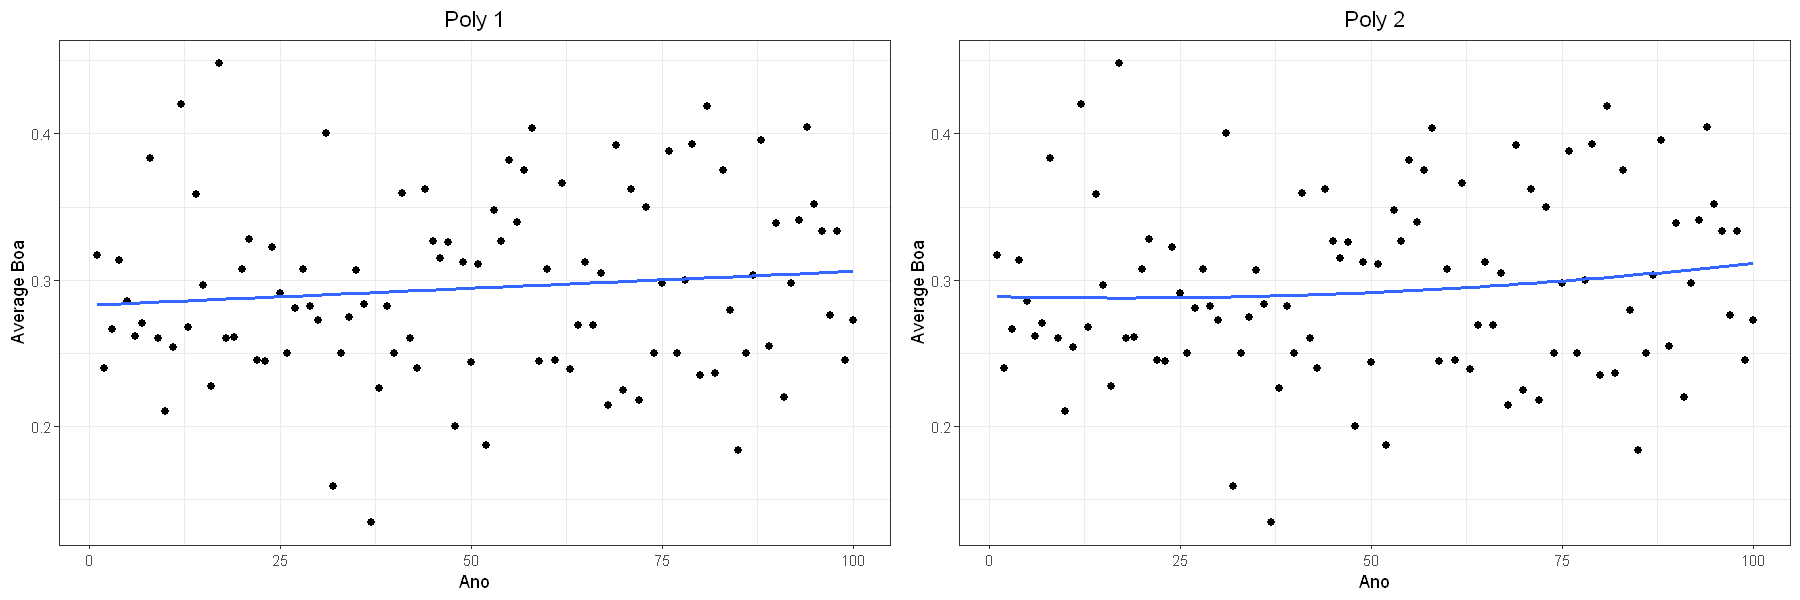

In [46]:
data2 <- data %>%
  mutate(ph_group = cut(pH, breaks = 100))

averages <- data2 %>%
  group_by(ph_group) %>%
  summarize(average_boa = mean(boa))


options(repr.plot.width = 15, repr.plot.height = 5)
chart <- ggplot(data = averages, aes(x = as.numeric(ph_group), y = average_boa)) +
  geom_point(size = 2) +
  theme_bw() +
  theme(legend.position = "none") +
  labs(x = "Ano", y = "Average Boa") +
  theme(plot.title = element_text(hjust = 0.5))


# Add polynomials regression line with titles
chart_poly1 <- chart + geom_smooth(method = "glm", formula = y ~ poly(x, 1), se = FALSE) + ggtitle("Poly 1")
chart_poly2 <- chart + geom_smooth(method = "glm", formula = y ~ poly(x, 2), se = FALSE) + ggtitle("Poly 2")

grid.arrange(chart_poly1, chart_poly2, ncol = 2)

### Testing Models

Variável de resposta y: boa

- Esta é a variável que estamos tentando modelar e prever. Representa a qualidade da pamonha.

GLM:

- Os GLMs são adequados quando a variável de resposta não segue uma distribuição normal, que é a suposição dos LMs. Os GLMs permitem diferentes tipos de distribuições de resposta, como Poisson, binomial ou gama, que podem lidar com dados de contagem, dados binários ou dados contínuos não negativos, respectivamente.

- Não linearidade: os GLMs podem lidar com relacionamentos não lineares entre os preditores e a variável de resposta. Usando funções de link apropriadas em GLMs, você pode modelar relacionamentos complexos, como relações logarítmicas, exponenciais ou de potência, que não podem ser capturados por LMs.

Família: 

- Binomial, pois a família binomial é comumente usada quando a variável de resposta é binária ou representa uma proporção. As curvas ROC, que normalmente são usadas para problemas de classificação binária. A variável de resposta test$boa é uma variável binária, indicando dois resultados possíveis (0 ou 1).

In [2]:
model_ic <- function(model) {
    return(c(AIC(model), BIC(model), AICc(model)))
}


In [3]:
ic_dataframe <- function(models) {
    aic_values <- c()
    bic_values <- c()
    aicc_values <- c()
    for (i in 1:length(models)) {      
        # Calculate evaluation metrics and append to the respective vectors
        result <- model_ic(models[[i]])
        aic_values <- c(aic_values, result[1])
        bic_values <- c(bic_values, result[2])
        aicc_values <- c(aicc_values, result[3])
    }
    df <- data.frame(Model = names(models),
        AIC = aic_values,
        BIC = bic_values,
        AICC = aicc_values)

    df
}

In [24]:
sample <- sample(c(TRUE, FALSE), nrow(data), replace=TRUE, prob=c(0.7,0.3)) # Create a vector of randomly sampled TRUE and FALSE values
train  <- data[sample, ] #training dataset
test   <- data[!sample, ] #testing dataset

#### Model 1: Binomial

$y$ = $\alpha$ + $\beta_0$ milho + $\beta_1$ temperatura + $\beta_2$ temperatura^2

In [26]:
model1 <- glm(boa ~ milho + poly(temperatura, 2),
                data = train, family = binomial)

ic_dataframe(list(model1 = model1))

Model,AIC,BIC,AICC
<chr>,<dbl>,<dbl>,<dbl>
model1,986.0893,1010.687,986.1008


#### Model 2: Binomial

$y$ = $\alpha$ + $\beta_0$ milho + $\beta_1$ ph + $\beta_2$ temperatura + $\beta_3$ temperatura^2

In [27]:
model2<- glm(boa ~ milho + pH + poly(temperatura, 2),
                data = train, family = binomial)

ic_dataframe(list(model2 = model2))

Model,AIC,BIC,AICC
<chr>,<dbl>,<dbl>,<dbl>
model2,944.1752,974.9218,944.1926


#### Model 3: Binomial

$y$ = $\alpha$ + $\beta_0$ milho + $\beta_1$ ph + $\beta_2$ ano + $\beta_3$ temperatura + $\beta_4$ tempertura^2

In [28]:
model3<- glm(boa ~ milho + pH + ano + poly(temperatura, 2),
                data = train, family = binomial)

ic_dataframe(list(model3 = model3))

Model,AIC,BIC,AICC
<chr>,<dbl>,<dbl>,<dbl>
model3,945.9142,982.8101,945.9385


#### Model 4: Binomial

$y$ = $\alpha$ + $\beta_0$ temperatura + $\beta_1$ ph + $\beta_2$ milho + $\beta_3$ ph*milho

In [29]:
model4<- glm(boa ~ temperatura + pH*milho + pH + milho,
                data = train, family = binomial)

ic_dataframe(list(model4 = model4))

Model,AIC,BIC,AICC
<chr>,<dbl>,<dbl>,<dbl>
model4,943.1142,973.8608,943.1316


#### Model 5: Binomial

$y$ = $\alpha$ + $\beta_0$ temperatura + $\beta_1$ ph + $\beta_2$ milho + $\beta_3$ ph*milho + $\beta_4$ ano

In [30]:
model5<- glm(boa ~ temperatura + pH*milho + ano,
                data = train, family = binomial)

ic_dataframe(list(model5 = model5))

Model,AIC,BIC,AICC
<chr>,<dbl>,<dbl>,<dbl>
model5,944.8842,981.7801,944.9085


#### Model Dica: Binomial

$y$ = $\alpha$ + $\beta_0$ milho + $\beta_1$ ph + $\beta_2$ ano + $\beta_3$ temperatura

In [31]:
model_tip<- glm(boa ~ milho + pH + ano + temperatura,
                data = train, family = binomial)

ic_dataframe(list(answer = model_tip))

Model,AIC,BIC,AICC
<chr>,<dbl>,<dbl>,<dbl>
answer,943.9247,974.6712,943.942


In [32]:
summary(model_tip)


Call:
glm(formula = boa ~ milho + pH + ano + temperatura, family = binomial, 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.1215  -0.1667  -0.0937   0.1943   3.4553  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -15.204816  17.386263  -0.875    0.382    
milhoComum    7.462823   0.275756  27.063  < 2e-16 ***
pH            2.151201   0.342806   6.275 3.49e-10 ***
ano           0.004378   0.008588   0.510    0.610    
temperatura  -0.242275   0.024563  -9.863  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 4166.86  on 3460  degrees of freedom
Residual deviance:  933.92  on 3456  degrees of freedom
AIC: 943.92

Number of Fisher Scoring iterations: 7


#### IC Comparison on Dataframe

In [33]:
models <- list(model1 = model1, model2 = model2, model3 = model3, model4 = model4, model5= model5, tip = model_tip)
ic_dataframe(models)

Model,AIC,BIC,AICC
<chr>,<dbl>,<dbl>,<dbl>
model1,986.0893,1010.6865,986.1008
model2,944.1752,974.9218,944.1926
model3,945.9142,982.8101,945.9385
model4,943.1142,973.8608,943.1316
model5,944.8842,981.7801,944.9085
tip,943.9247,974.6712,943.9420


### Plotting ROC Models 

Setting levels: control = 0, case = 1

Setting direction: controls < cases



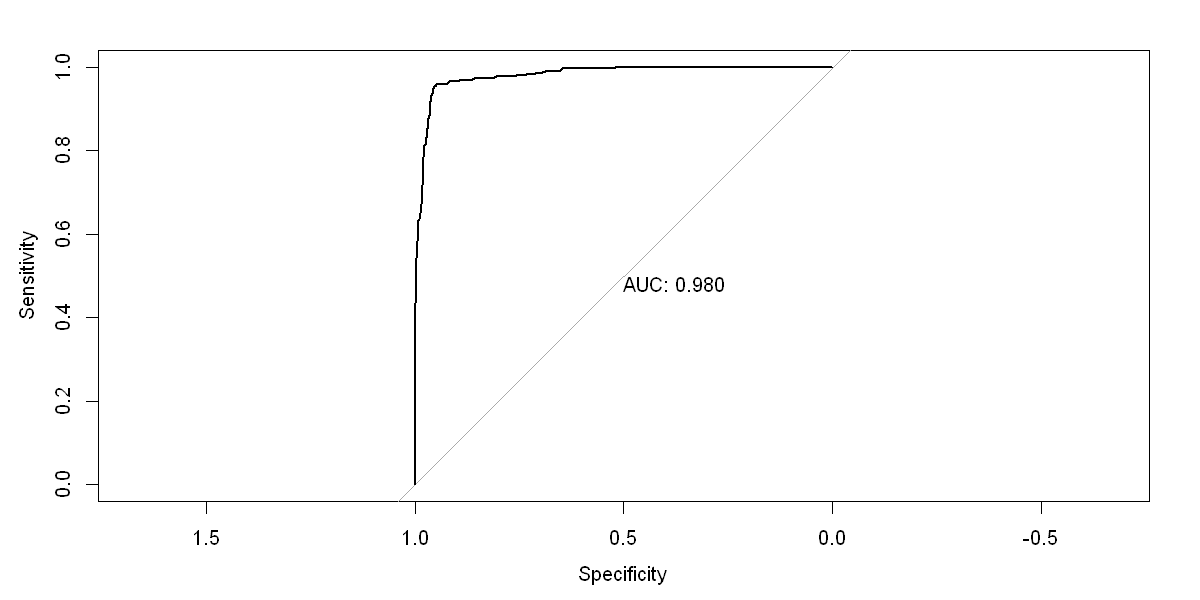

In [34]:
options(repr.plot.width = 10, repr.plot.height = 5)

y_hat1 = predict(model1, newdata = test, type="response")
teste_roc1 = roc(test$boa ~ y_hat1, plot=TRUE, print.auc=TRUE)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



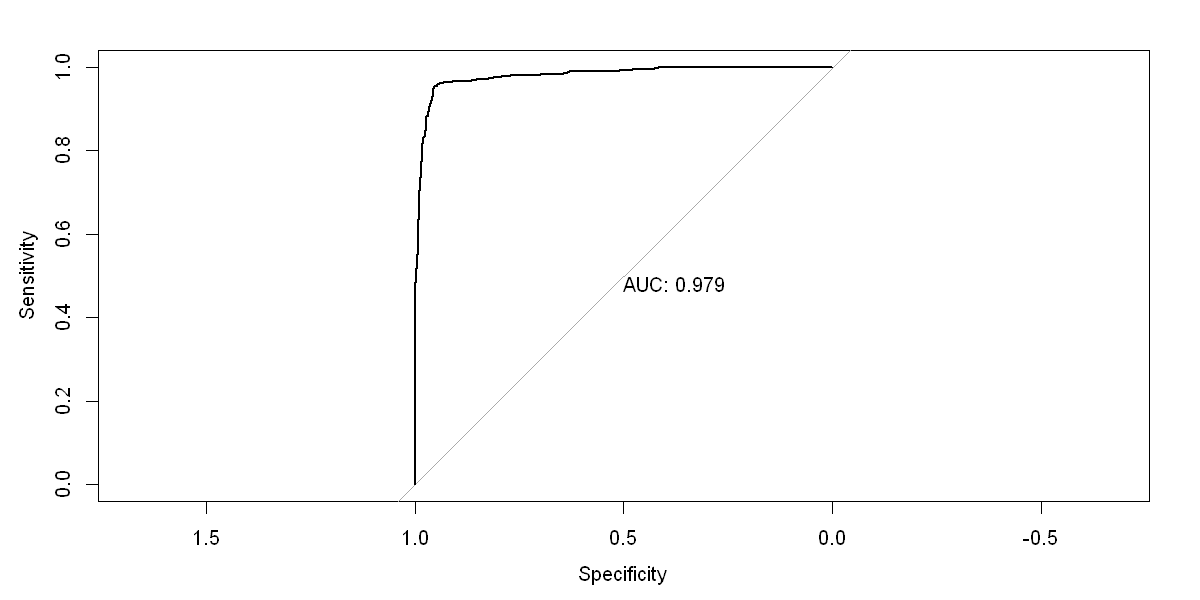

In [35]:
y_hat2 = predict(model2, newdata = test, type="response")
teste_roc2 = roc(test$boa ~ y_hat2, plot=TRUE, print.auc=TRUE)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



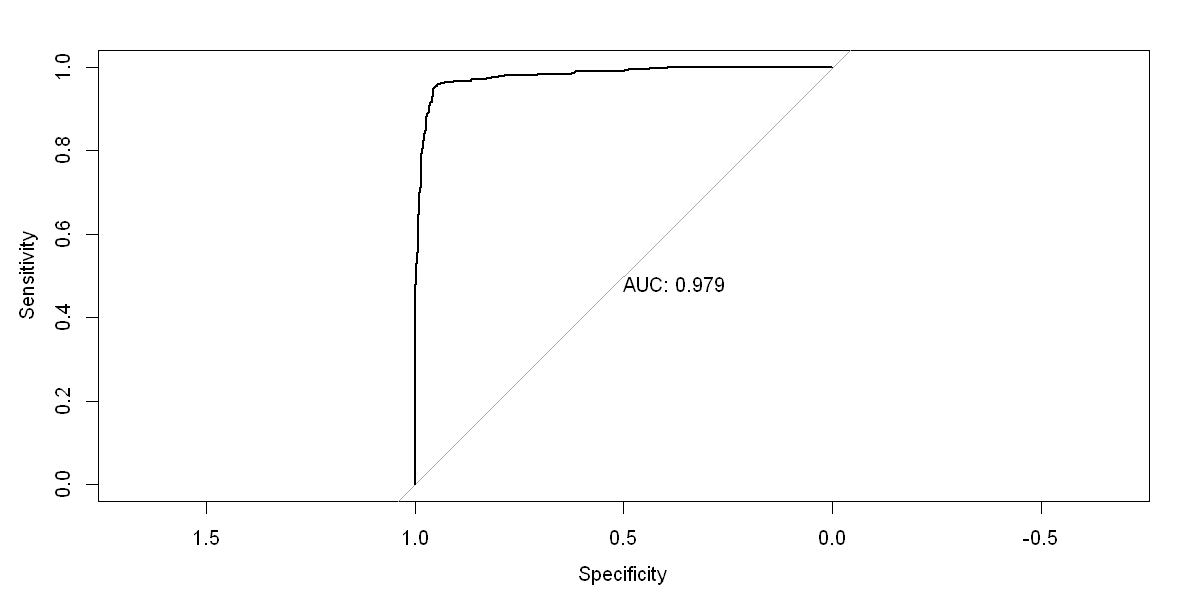

In [36]:
y_hat3 = predict(model3, newdata = test, type="response")
teste_roc3 = roc(test$boa ~ y_hat3, plot=TRUE, print.auc=TRUE)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



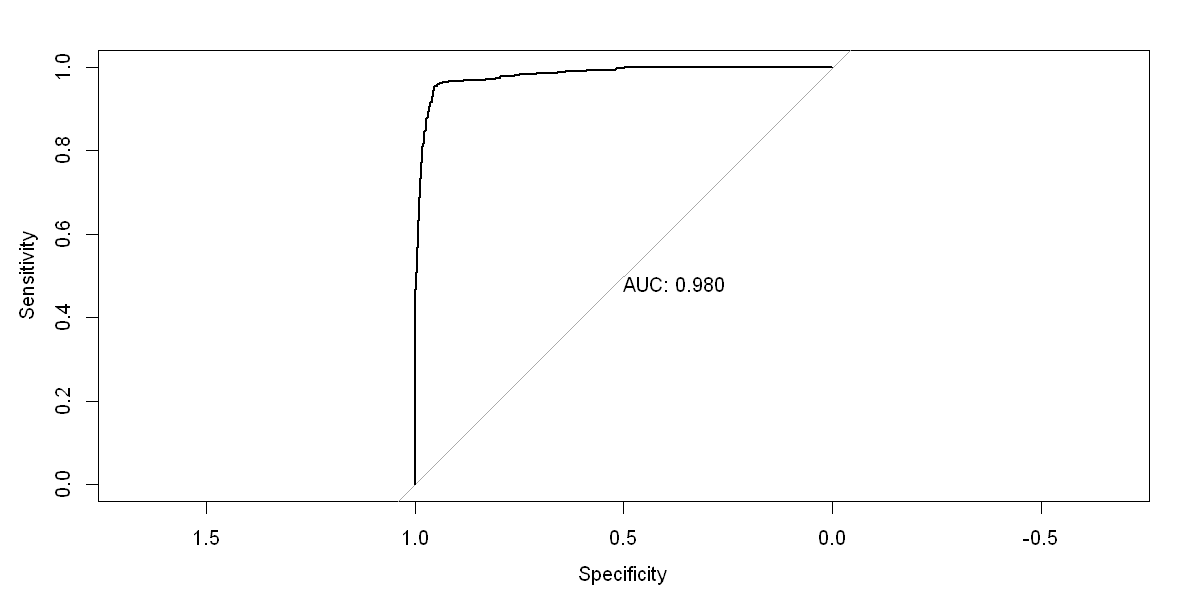

In [40]:
y_hat_answer = predict(model4, newdata = test, type="response")
teste_roc4 = roc(test$boa ~ y_hat_answer, plot=TRUE, print.auc=TRUE)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



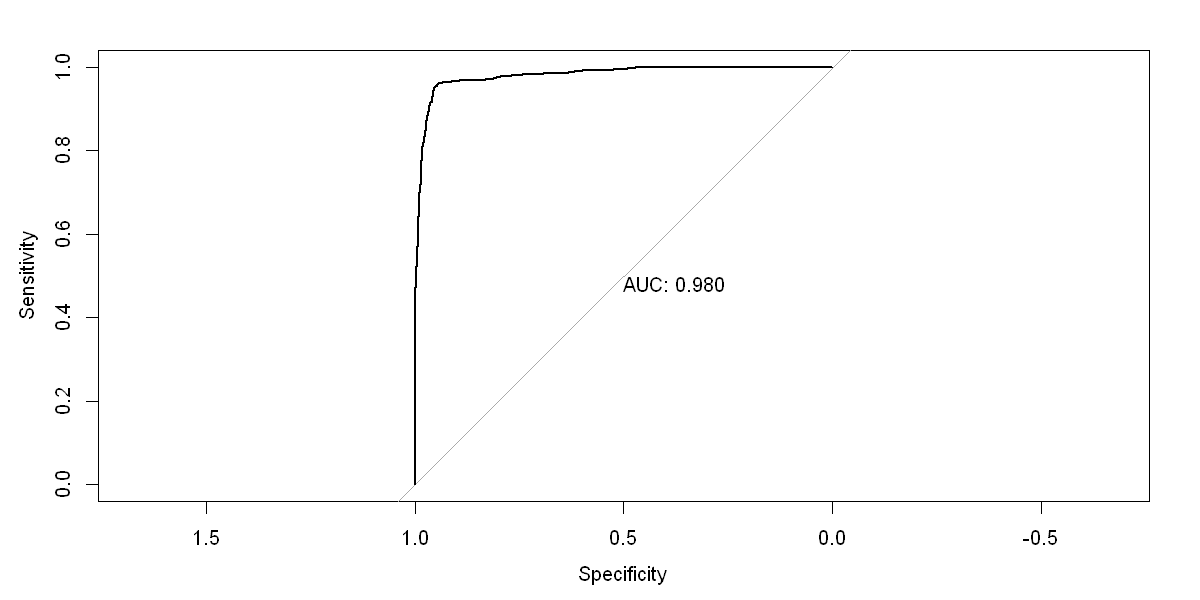

In [43]:
y_hat_answer = predict(model5, newdata = test, type="response")
teste_roc5 = roc(test$boa ~ y_hat_answer, plot=TRUE, print.auc=TRUE)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



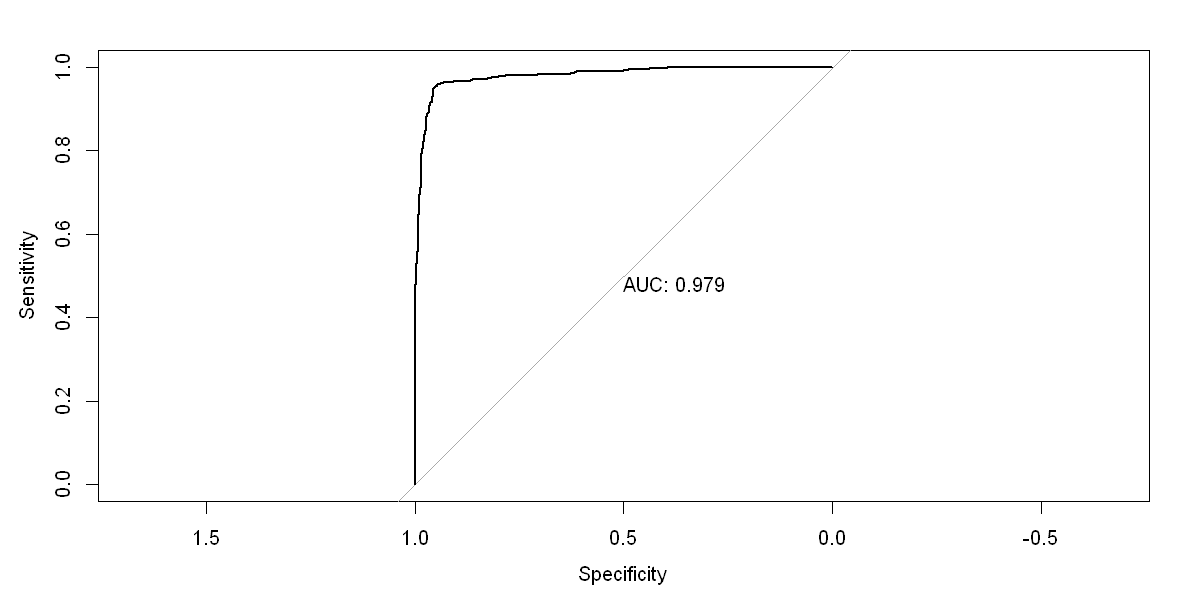

In [41]:
y_hat_answer = predict(model_tip, newdata = test, type="response")
teste_roc_answer = roc(test$boa ~ y_hat_answer, plot=TRUE, print.auc=TRUE)